In [1]:
####
#Perform the heat budget analsysis in a spatial manner
#Import required modules
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import os
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar


In [9]:
EC_Earth3_dir = '/g/data/e14/sm2435/CMIP6/EC-Earth3/'
#load in all full DS to get climatology
U=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'UO/*.nc' ))
V=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'VO/*.nc' ))
#W is downwards postive, we want upwelling to show as pos, so reverse sign
W=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'WO/*.nc' ))
T=xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'THETAO/*.nc' ))
#alter W coord
#only want W at bottom of layer
#W = 
#W = W.assign_coords(lev = T.lev)

#restrict data down to 9 gridcell block
U = U.sel(lat=slice(-40,40),lon=slice(30,120))
V = V.sel(lat=slice(-40,40),lon=slice(30,120))
W = W.sel(lat=slice(-40,40),lon=slice(30,120))
T = T.sel(lat=slice(-40,40),lon=slice(30,120))

/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
/apps/xarray/0.15.1-py3.7/lib/python3.7/site-packages/xarray-0.15.1-py3.7.egg/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. 

In [59]:
dTdz = -1*((T.thetao[:,-2] - T.thetao[:,0])/T.lev[-2])
W = W.wo[:,-1]

AttributeError: 'DataArray' object has no attribute 'wo'

In [44]:
W

,Array,Chunk
Bytes,57.02 MB,345.60 kB
Shape,"(1980, 80, 90)","(12, 80, 90)"
Count,827 Tasks,165 Chunks
Type,float32,numpy.ndarray


In [45]:
dTdt = T.thetao.chunk(1980, 20,3,3).differentiate(coord = 'time',datetime_unit= 's')
dTdx = T.thetao.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
dTdy = T.thetao.differentiate('lat') / 110e3 
#dTdz = -1*(T.thetao.differentiate('lev'))


In [47]:
u = U.uo
v = V.vo
#w = W.wo

#only want W at bottom layer
#w = w[:,0]


In [49]:
#now get terms
uadv = u*dTdx
vadv = v*dTdy
wadv = W*dTdz

In [50]:
#load in q and get qnet
Q = xr.open_dataset('/g/data/e14/sm2435/CMIP6/EC-Earth3/EC-Earth3_HFDS.nc')
#get qnet and subset
qpch = (Q.hfds/(3986*1026*61.11283875)).sel(lat=slice(-40,40),lon=slice(30,120))


In [51]:
uadv.load()
vadv.load()
wadv.load()
qpch.load()
dTdt.load()

<xarray.DataArray 'thetao' (time: 1980, lev: 20, lat: 80, lon: 90)>
array([[[[ 4.68649660e-07,  5.27634711e-07,  5.84132238e-07, ...,
           6.78422111e-07,  7.05829393e-07,  7.28411408e-07],
         [ 5.48817695e-07,  5.94323012e-07,  6.26028395e-07, ...,
           7.16792783e-07,  7.38519873e-07,  7.65726270e-07],
         [ 5.83557551e-07,  6.29952638e-07,  6.33544630e-07, ...,
           6.96220411e-07,  7.05983894e-07,  6.73582633e-07],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan, -9.03414389e-07, -9.69239295e-07],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 4.68598017e-07,  5.26986639e-07,  5.84254224e-07, ...,
           6.77921435e-07,  7.04925014e-07,  7.27466272e-07],
         [ 5.48360504e-07,  5.94242977e-07,  6.25776920e-07, ...,
           7.16792044e-07,  7.38720416e-07,  7.65063987e-07],
         [ 5.82508392e-07,  6.29405577e-07,  6.31455293e-07, ...,
           6.92566289e-07,  7.01380941e-07,  6.72118119e-07],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan, -9.03984414e-07, -9.69555117e-07],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 4.68491010e-07,  5.25968915e-07,  5.84345514e-07, ...,
           6.78225661e-07,  7.04150864e-07,  7.26193377e-07],
         [ 5.48536320e-07,  5.95257688e-07,  6.26359906e-07, ...,
           7.15436840e-07,  7.34803677e-07,  7.62786783e-07],
         [ 5.82556254e-07,  6.29579972e-07,  6.31684259e-07, ...,
           6.90755371e-07,  6.97968517e-07,  6.69742178e-07],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan, -9.04387093e-07, -9.70087854e-07],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[ 3.09302095e-07,  2.67808559e-07,  2.44417947e-07, ...,
           1.46529018e-07,  1.71940499e-07,  1.87027624e-07],
         [ 4.15598919e-07,  3.78610338e-07,  3.42264599e-07, ...,
           3.34464005e-07,  3.43066461e-07,  2.87764720e-07],
         [ 4.33809561e-07,  4.20038759e-07,  3.76015123e-07, ...,
           4.89272168e-07,  4.66180154e-07,  2.88306893e-07],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan, -9.74260388e-07],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 2.62352472e-07,  2.23647248e-07,  2.05010039e-07, ...,
           1.43021964e-07,  1.53285342e-07,  1.45064163e-07],
         [ 3.61950242e-07,  3.26958968e-07,  2.98268674e-07, ...,
           2.73807188e-07,  2.81988349e-07,  2.35566688e-07],
         [ 3.70327058e-07,  3.65969527e-07,  3.37537386e-07, ...,
           3.73055855e-07,  3.69881064e-07,  2.27106042e-07],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan, -9.74278123e-07],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

In [52]:
weights = dTdt.lev
wt=np.array([0.])
for i in range(len(weights.values)):
    #print(i)
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
    #print (NW)

In [53]:
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'lev': T.lev},
             dims=['lev'])

In [54]:
#now calculate the weighted avergae of each term
dTdt_thickness=dTdt.weighted(thickness_DA).mean('lev')
uadv_thickness=uadv.weighted(thickness_DA).mean('lev')
vadv_thickness=vadv.weighted(thickness_DA).mean('lev')
#wadv_thickness=-1*wadv.weighted(thickness_DA).mean('lev')

In [55]:
dTdt_thickness

<xarray.DataArray (time: 1980, lat: 80, lon: 90)>
array([[[ 4.15078259e-07,  4.08236681e-07,  4.12422169e-07, ...,
          4.76618992e-07,  4.88385647e-07,  4.98728496e-07],
        [ 4.89440128e-07,  4.81311586e-07,  4.68883867e-07, ...,
          5.62012789e-07,  5.67150464e-07,  5.48248069e-07],
        [ 5.09326886e-07,  5.14167251e-07,  4.89218735e-07, ...,
          5.81420386e-07,  5.67571269e-07,  4.87081582e-07],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan, -9.05566414e-07, -9.73201440e-07],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 3.27876118e-07,  2.94508734e-07,  2.81751451e-07, ...,
          3.64788409e-07,  3.74969541e-07,  3.77348944e-07],
        [ 3.43824071e-07,  3.21112401e-07,  3.16270407e-07, ...,
          4.50693254e-07,  4.44808529e-07,  4.10337193e-07],
        [ 3.28504710e-07,  3.28889716e-07,  3.33359119e-07, ...,
          4.44462128e-07,  4.15735788e-07,  3.48279647e-07],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan, -3.48249515e-07, -5.78104171e-07],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 2.93146604e-08,  1.10111859e-08, -9.47448343e-09, ...,
          9.47908198e-08,  9.47359502e-08,  8.24982749e-08],
        [-2.24697918e-08, -2.62883349e-08, -3.30714434e-08, ...,
          1.75972474e-07,  1.50419650e-07,  1.05218209e-07],
        [-7.72420653e-08, -6.27197389e-08, -4.53617608e-08, ...,
          1.43516547e-07,  1.01253505e-07,  6.13905881e-08],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,  6.00406484e-07,  1.43130920e-07],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       ...,

       [[ 2.45312834e-07,  2.10929211e-07,  1.76051227e-07, ...,
          1.98441490e-07,  2.00238838e-07,  2.06625862e-07],
        [ 2.60262255e-07,  2.31647069e-07,  1.92780971e-07, ...,
          2.11563911e-07,  2.21100021e-07,  2.31830104e-07],
        [ 2.63586876e-07,  2.30020296e-07,  1.85334167e-07, ...,
          2.62040933e-07,  2.76664402e-07,  2.82052155e-07],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan, -1.62041419e-06, -4.33971566e-07],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 3.28260247e-07,  3.34415319e-07,  3.25530560e-07, ...,
          4.29095778e-07,  4.32744854e-07,  4.36163006e-07],
        [ 3.55396815e-07,  3.60782489e-07,  3.60649218e-07, ...,
          4.43322786e-07,  4.49982168e-07,  4.56030036e-07],
        [ 3.71210761e-07,  3.70597611e-07,  3.64196357e-07, ...,
          4.90680186e-07,  4.94443333e-07,  4.83754368e-07],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan, -1.95035064e-06, -6.54811632e-07],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 3.71938395e-07,  4.00063697e-07,  4.13173547e-07, ...,
          4.97409

In [57]:
#get climatology of these terms and then plot them
uadv_c = uadv_thickness.groupby('time.month').mean('time')
vadv_c = vadv_thickness.groupby('time.month').mean('time')
wadv_c = wadv.groupby('time.month').mean('time')
dTdt_c = dTdt_thickness.groupby('time.month').mean('time')
qpch_c = qpch.groupby('time.month').mean('time')

In [ ]:
np.nanmax(qpch_c.values)

In [ ]:
fig, axes = plt.subplots(nrows=12, ncols=5, figsize=(15, 18), sharey='all', sharex='all')
for i in range(0,12):
    axes[i, 0].contourf(dTdt_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], levels = 51, cmap = 'RdBu_r', 
                        add_colorbar=False, vmin = -1e-6, vmax = 1e-6)
    axes[i, 0].set_ylabel('yesysysysysys')

for i in range(0,12):
    axes[i, 1].contourf(uadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], levels = 51, cmap = 'RdBu_r', 
                        add_colorbar=False, vmin = -1e-6, vmax = 1e-6)
for i in range(0,12):
    axes[i, 2].contourf(vadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], levels = 51, cmap = 'RdBu_r', 
                        add_colorbar=False, vmin = -1e-6, vmax = 1e-6)
for i in range(0,12):
    axes[i, 3].contourf(wadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], levels = 51, cmap = 'RdBu_r', 
                        add_colorbar=False, vmin = -1e-6, vmax = 1e-6)
for i in range(0,12):
    axes[i, 4].contourf(qpch_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], levels = 51, cmap = 'RdBu_r', 
                        add_colorbar=False, vmin = -1e-6, vmax = 1e-6)
plt.tight_layout()

/apps/cartopy/0.18.0-py3.7/lib/python3.7/site-packages/Cartopy-0.18.0-py3.7-linux-x86_64.egg/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/apps/jupyterlab/2.1.4-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


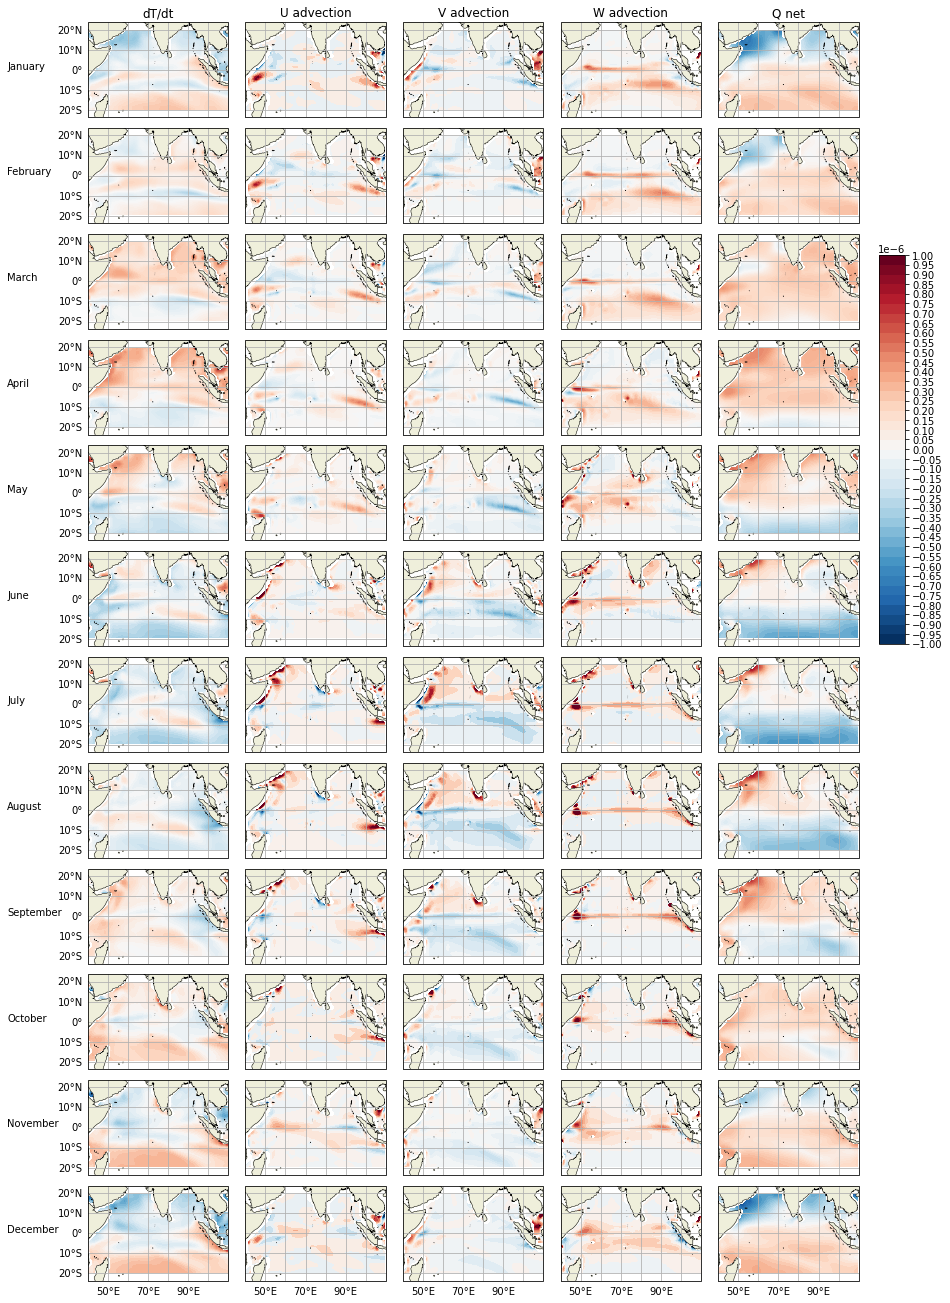

In [60]:
def plot_background(ax, i, j):
    ax.set_extent([40., 110., -20., 20.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    if i == 11:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    if j > 0:
        gl.left_labels = False
    return ax


fig, axes = plt.subplots(nrows=12, ncols=5, figsize=(12, 18), sharey='all', sharex='all', 
                         subplot_kw={'projection':ccrs.PlateCarree()})
lons = dTdt_c.sel(lat=slice(-20,20),lon=slice(40,110)).lon
lats = dTdt_c.sel(lat=slice(-20,20),lon=slice(40,110)).lat
#dTdt
axes[0,0].set_title('dT/dt')
for i in range(0,12):
    axes[i, 0].contourf(lons, lats, dTdt_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    #anchor text at side of plot for label
    axes[i, 0].text(-0.1,0.5, str(calendar.month_name[dTdt_c.month.values[i]]))
    plot_background(axes[i, 0], i, 0)
    
#U
axes[0,1].set_title('U advection')
for i in range(0,12):
    axes[i, 1].contourf(lons, lats, uadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 1], i, 1)
#V
axes[0,2].set_title('V advection')

for i in range(0,12):
    axes[i, 2].contourf(lons, lats, vadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 2], i, 2)
#W
axes[0,3].set_title('W advection')

for i in range(0,12):
    axes[i, 3].contourf(lons, lats, -1*wadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 3], i, 3)
#Q
axes[0,4].set_title('Q net')

for i in range(0,12):
    fill = axes[i, 4].contourf(lons, lats, qpch_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 4], i, 4)
cbar_ax2 = fig.add_axes([1, 0.5, 0.03, 0.3])
cmap2 = plt.cm.RdBu_r
bounds = np.linspace(-1.e-6, 1.e-6, 41)
norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N)
cb = mpl.colorbar.ColorbarBase(cbar_ax2, cmap=cmap2, norm=norm2,
    spacing='proportional', ticks=bounds, boundaries=bounds)
fig.tight_layout()

In [ ]:
fig.savefig('/home/561/sm2435/Documents/figures/Month_spatial1.png', dpi = 300, bbox_inches='tight')

In [ ]:
plt.cm.RdBu_r

In [ ]:
#load in sw variable
SW = xr.open_mfdataset(os.path.join(EC_Earth3_dir, 'RSDO/*.nc' ))
#restrict data down to 9 gridcell block
SW = SW.sel(lat=slice(-40,40),lon=slice(30,120))

In [ ]:
import math
test = SW.rsdo[:,0]*((0.58*math.exp(-SW.lev[-1]/0.35))+((1-0.58)*math.exp(-SW.lev[-1]/23)))


In [ ]:
test[0].plot()

In [ ]:
SW.rsdo[0,0].plot()

In [ ]:
SW

In [ ]:
sum_T = qpch - (uadv_thickness + uadv_thickness + wadv_thickness)
sum_T_C = sum_T.groupby('time.month').mean('time')

fig, axes = plt.subplots(nrows=12, ncols=6, figsize=(14, 20), sharey='all', sharex='all', 
                         subplot_kw={'projection':ccrs.PlateCarree()})
lons = dTdt_c.sel(lat=slice(-20,20),lon=slice(40,110)).lon
lats = dTdt_c.sel(lat=slice(-20,20),lon=slice(40,110)).lat
#dTdt
axes[0,0].set_title('dT/dt')
for i in range(0,12):
    axes[i, 0].contourf(lons, lats, dTdt_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    #anchor text at side of plot for label
    axes[i, 0].text(-0.1,0.5, str(calendar.month_name[dTdt_c.month.values[i]]))
    plot_background(axes[i, 0], i, 0)
#U
axes[0,1].set_title('U advection')
for i in range(0,12):
    axes[i, 1].contourf(lons, lats, uadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 1], i, 1)
#V
axes[0,2].set_title('V advection')

for i in range(0,12):
    axes[i, 2].contourf(lons, lats, vadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 2], i, 2)
#W
axes[0,3].set_title('W advection')

for i in range(0,12):
    axes[i, 3].contourf(lons, lats, wadv_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 3], i, 3)
#Q
axes[0,4].set_title('Q net')

for i in range(0,12):
    fill = axes[i, 4].contourf(lons, lats, qpch_c.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 4], i, 4)    
#sum
axes[0,5].set_title('Qnet - advection')
for i in range(0,12):
    axes[i, 5].contourf(lons, lats, sum_T_C.sel(lat=slice(-20,20),lon=slice(40,110))[i], 
                        levels = 41, cmap = 'RdBu_r', 
                        add_colorbar=True, vmin = -1e-6, vmax = 1e-6, 
                        transform=ccrs.PlateCarree())
    plot_background(axes[i, 5], i, 1)
cbar_ax2 = fig.add_axes([1, 0.5, 0.03, 0.3])
cmap2 = plt.cm.RdBu_r
bounds = np.linspace(-1.e-6, 1.e-6, 41)
norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N)
cb = mpl.colorbar.ColorbarBase(cbar_ax2, cmap=cmap2, norm=norm2,
    spacing='proportional', ticks=bounds, boundaries=bounds)

fig.tight_layout()


In [ ]:
fig.savefig('/home/561/sm2435/Documents/figures/Month_spatial_w_corr.png', dpi = 300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(8,12))
plt.plot(range(1,21), T.lev)
plt.xticks(range(1,21))
plt.yticks(T.lev)
plt.plot(range(1,21), W.lev)
#plt.xticks(range(1,21))
#plt.yticks(T.lev)


In [ ]:
W.wo[100,-1].plot()

In [ ]:
T.lev